In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import os
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import math

## Download Pre-trained word vectors Glove zip
http://nlp.stanford.edu/data/glove.6B.zip  
Unzip 6B zip file from Downloads  
Copy "glove.6B.300d.txt" from unzipped folder  
Create folder named "data" and paste copied text file into "data"

## Import Pre-trained word vectors from Glove

In [2]:
glove_file = datapath(os.getcwd()+"/data/glove.6B.300d.txt")
word2vec_glove_file = get_tmpfile(os.getcwd()+"/data/glove.6B.300d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)
model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

### Examine word vector

In [3]:
model['cat']

array([-0.29353  ,  0.33247  , -0.047372 , -0.12247  ,  0.071956 ,
       -0.23408  , -0.06238  , -0.0037192, -0.39462  , -0.69411  ,
        0.36731  , -0.12141  , -0.044485 , -0.15268  ,  0.34864  ,
        0.22926  ,  0.54361  ,  0.25215  ,  0.097972 , -0.087305 ,
        0.87058  , -0.12211  , -0.079825 ,  0.28712  , -0.68563  ,
       -0.27265  ,  0.22056  , -0.75752  ,  0.56293  ,  0.091377 ,
       -0.71004  , -0.3142   , -0.56826  , -0.26684  , -0.60102  ,
        0.26959  , -0.17992  ,  0.10701  , -0.57858  ,  0.38161  ,
       -0.67127  ,  0.10927  ,  0.079426 ,  0.022372 , -0.081147 ,
        0.011182 ,  0.67089  , -0.19094  , -0.33676  , -0.48471  ,
       -0.35406  , -0.15209  ,  0.44503  ,  0.46385  ,  0.38409  ,
        0.045081 , -0.59079  ,  0.21763  ,  0.38576  , -0.44567  ,
        0.009332 ,  0.442    ,  0.097062 ,  0.38005  , -0.11881  ,
       -0.42718  , -0.31005  , -0.025058 ,  0.12689  , -0.13468  ,
        0.11976  ,  0.76253  ,  0.2524   , -0.26934  ,  0.0686

### Similarity between two words

In [4]:
model.similarity("man", "woman")

/Users/hor/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.6998663

### Vector arithmetics of words

In [5]:
model.most_similar(positive=['mother', 'son'], negative=['father'], topn=3)

/Users/hor/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('daughter', 0.8807988166809082),
 ('wife', 0.7806316018104553),
 ('daughters', 0.709545373916626)]

## Fetch 20 News Groups Data
4 categories
 - gun politics
 - christianity
 - computer graphics
 - science medical

In [6]:
categories = ['talk.politics.guns', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
print(twenty_train.target_names) # news categories used
print(len(twenty_train.data))
print(len(twenty_train.filenames))

['comp.graphics', 'sci.med', 'soc.religion.christian', 'talk.politics.guns']
2323
2323


## Define LSTM network

In [7]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, layer_dim=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layer_dim = layer_dim
        self.lstm1 = nn.LSTM(input_size=300, hidden_size=hidden_size, num_layers=layer_dim, batch_first=True, bidirectional=True, dropout=0.4)
        self.fc1 = nn.Linear(hidden_size*2, 20) # hidden_size *2 because of bidirectional
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 4)
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, inputs):
        out, (hn, cn) = self.lstm1(inputs)
        hn_flat = torch.cat((hn[0], hn[1]), dim=1)
        out = F.relu(self.fc1(hn_flat))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        return out
    
net = LSTM(hidden_size=20, layer_dim=3)

## Prepare training data

#### Add spaces before and after punctuation

In [8]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

#### Example of preprocessing our data

In [9]:
print(clean_text(twenty_train.data[2]).replace('\n', ' ').lower().split())

['from', ':', 'petch', '@', 'gvg47', '.', 'gvg', '.', 'tek', '.', 'com', '(', 'chuck', 'petch', ')', 'subject', ':', 'daily', 'verse', 'organization', ':', 'grass', 'valley', 'group', ',', 'grass', 'valley', ',', 'ca', 'lines', ':', '4', 'for', 'whoever', 'does', 'the', 'will', 'of', 'my', 'father', 'in', 'heaven', 'is', 'my', 'brother', 'and', 'sister', 'and', 'mother', '.', '"', 'matthew', '12', ':', '50']


### Visualize sequence length distribution to determine appropriate bin separations

(0, 1000)

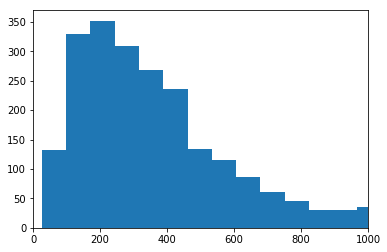

In [10]:
pos_word_length_dist = []
for article in twenty_train.data:
    cleaned_article = clean_text(article).replace('\n', ' ').lower().split()
    pos_word_length_dist.append(len(cleaned_article))

plt.hist(pos_word_length_dist, bins=400)
plt.xlim(0, 1000)
#sns.distplot(pos_word_length_dist)

### Parse data into bins to feed into model

In [26]:
def shuffle(data, target):
    random_seed = np.random.randint(low=len(data), size=len(data))
    shuffled_data = data[random_seed]
    shuffled_target = target[random_seed]
    return (shuffled_data, shuffled_target)

# Sequence is a 2D vector, A sentence is a sequence of words represented as word vector
def fix_sequence_size(sequence, size):
    if len(sequence) == size:
        return sequence
    elif len(sequence) > size:
        # Truncate
        return sequence[:size]
    elif len(sequence) < size:
        # Pad zeros
        word_vec_size = sequence[0].size
        return np.concatenate((sequence, np.zeros((int(size-len(sequence)), word_vec_size), dtype=float)))

def organize_into_bins(documents, target, num_bins):
    bin_input = []
    bin_target = []
    batch_lengths = []
    for i in range(num_bins):
        bin_input.append([])
        bin_target.append([])
        batch_lengths.append([])
    
    for i in range(0, len(documents)):
        if len(documents[i]) <= 1000:
            index = len(documents[i]) // 100
            batch_lengths[index].append(len(documents[i]))
        else:
            batch_lengths[10].append(len(documents[i]))
            
    for i in range(0, len(documents)):
        if len(documents[i]) <= 1000:
            index = len(documents[i]) // 100
            # within a bin, keep word length of documents the same e.g. 80 percentile of the word length
            # pad documents less than the 80 percentile length of bin and truncate documents above the 80 percentile length of bin
            cutoff = math.floor(np.percentile(np.array(batch_lengths[index]), q=80))
            bin_input[index].append(fix_sequence_size(documents[i], cutoff))
            bin_target[index].append(target[i])
        else:
            bin_input[10].append(fix_sequence_size(documents[i], 1000))
            bin_target[10].append(target[i])
    return(bin_input, bin_target)

### Preprocess raw data and place into appropriate bins

In [27]:
WORD_VECTOR_SIZE=300
data = []
target = []
for i in range(0, len(twenty_train.data)):
    article_vector = []
    cleaned_article = clean_text(twenty_train.data[i]).replace('\n', ' ').lower().split()
    for word in cleaned_article:
        try:
            article_vector.append(model[word])
        except KeyError:
            article_vector.append(np.zeros(WORD_VECTOR_SIZE, dtype=float))
    data.append(article_vector)
    target.append(twenty_train.target[i])

(data, target) = shuffle(data=np.array(data), target=np.array(target))
input_test = data[:300]
target_test = target[:300]
input_validation = data[300:600]
target_validation = target[300:600]
input_train = data[600:]
target_train = target[600:]
(bin_input, bin_target) = organize_into_bins(documents=input_train, target=target_train, num_bins=11)
(bin_input_validation, bin_target_validation) = organize_into_bins(documents=input_validation, target=target_validation, num_bins=11)

In [41]:
print(np.array(bin_input[7]).shape)
print(np.array(bin_target[7]).shape)

(55, 775, 300)
(55,)


## Train LSTM model

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

for epoch in range(35):  # loop over the dataset multiple times
    running_loss = 0.0
    running_validation_loss = 0.0
    for i in range(0, len(bin_input)):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        net.train()
        
        batch_input = np.array(bin_input[i])
        batch_target = np.array(bin_target[i])
        batch_input = torch.from_numpy(batch_input)
        batch_input = batch_input.type(torch.float)
        batch_target = torch.from_numpy(batch_target)
        batch_target = batch_target.type(torch.long)
        
        # forward + backward + optimize
        outputs = net(batch_input)
        #print(outputs.shape)
        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        with torch.no_grad():
            net.eval()
            batch_input_validation = np.array(bin_input_validation[i])
            batch_target_validation = np.array(bin_target_validation[i])
            batch_input_validation = torch.from_numpy(batch_input_validation)
            batch_input_validation = batch_input_validation.type(torch.float)
            batch_target_validation = torch.from_numpy(batch_target_validation)
            batch_target_validation = batch_target_validation.type(torch.long)

            validation_outputs = net(batch_input_validation)
            validation_loss = criterion(validation_outputs, batch_target_validation)
            net.train() 
            running_validation_loss += validation_loss.item()

    print("Running Loss: " + str((running_loss / len(bin_input))) + " |  Validation Loss: " + str((running_validation_loss / len(bin_input))))

print('Finished Training')

Running Loss: 1.4142707694660535 |  Validation Loss: 1.409272475676103
Running Loss: 1.3824527588757602 |  Validation Loss: 1.3743045221675525
Running Loss: 1.3690865148197522 |  Validation Loss: 1.3516438657587224
Running Loss: 1.3644776994531804 |  Validation Loss: 1.3412442749196833
Running Loss: 1.3323088884353638 |  Validation Loss: 1.3174712332812222
Running Loss: 1.318755648352883 |  Validation Loss: 1.2951932061802258
Running Loss: 1.2542007077823987 |  Validation Loss: 1.2439989826895974
Running Loss: 1.1180026097731157 |  Validation Loss: 1.102182854305614
Running Loss: 1.0836339863863858 |  Validation Loss: 0.9979432821273804
Running Loss: 0.9779805270108309 |  Validation Loss: 0.9215782691131938
Running Loss: 0.8619511777704413 |  Validation Loss: 0.9749049165032126
Running Loss: 0.8371564583344893 |  Validation Loss: 0.9821085333824158
Running Loss: 0.8146158185872164 |  Validation Loss: 0.7343922257423401
Running Loss: 0.6901520897041667 |  Validation Loss: 0.677622010762

KeyboardInterrupt: 

In [50]:
from sklearn.metrics import classification_report, confusion_matrix  

def predict_from_vector(review_vector):
    review_tensor = torch.tensor(review_vector, dtype=torch.float)
    review_tensor = review_tensor.view(1, len(review_vector), 300)
    prediction = net(review_tensor)
    return torch.argmax(prediction.view(prediction.size(1)))

def class_report(input_test, ground_truth):
    prediction = []
    for document_vector in input_test:
        prediction.append(predict_from_vector(document_vector))
    prediction = np.array(prediction)
    ground_truth = np.array(ground_truth)
    print(confusion_matrix(ground_truth, prediction))  
    print(classification_report(ground_truth, prediction))

In [52]:
class_report(input_test=input_test, ground_truth=target_test)

[[52  5 11  6]
 [ 6 61  1 18]
 [ 8  0 53  2]
 [ 4  9  4 60]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        74
           1       0.81      0.71      0.76        86
           2       0.77      0.84      0.80        63
           3       0.70      0.78      0.74        77

   micro avg       0.75      0.75      0.75       300
   macro avg       0.76      0.76      0.75       300
weighted avg       0.76      0.75      0.75       300

